The unit of interest:

In [74]:
myEstate="127 Harvey St, Cambridge, MA 02140"

It is an entire unit with three bedrooms.

In [75]:
!pip install pysal h3

In [76]:
import pandas as pd
import geopandas as gpd

linkMA="https://raw.githubusercontent.com/madisonhess/Homework_2/refs/heads/main/municipalities.zip"
ma_towns=gpd.read_file(linkMA)

linkCambridgeAirbnb="https://raw.githubusercontent.com/madisonhess/Homework_2/refs/heads/main/listings.csv"
airbnb_all=pd.read_csv(linkCambridgeAirbnb)

cambridge=ma_towns[ma_towns['town'] == 'CAMBRIDGE'] #filtering for cambridge
cambridge

,id,town,town_id,type,county,fips_stco,fourcolor,pop1960,pop1970,pop1980,pop1990,pop2000,pop2010,pop2020,popch10_20,area_acres,area_sqmi,gdb_geomattr_data,geometry
9,GISDATA.TOWNSSURVEY_POLYM.16,CAMBRIDGE,49,C,MIDDLESEX,25017,3,107716,100361,95322,95802,101355,105162,118403,13241,4546.96,7.105,None,"POLYGON ((230353.943 905738.525, 230689.843 90..."


Cleaning up the Airbnb file:

In [77]:
airbnb_all.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1358 entries, 0 to 1357
Data columns (total 79 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            1358 non-null   int64  
 1   listing_url                                   1358 non-null   object 
 2   scrape_id                                     1358 non-null   int64  
 3   last_scraped                                  1358 non-null   object 
 4   source                                        1358 non-null   object 
 5   name                                          1358 non-null   object 
 6   description                                   1347 non-null   object 
 7   neighborhood_overview                         694 non-null    object 
 8   picture_url                                   1358 non-null   object 
 9   host_id                                       1358 non-null   i

In [78]:
keep=['id','price','bedrooms','property_type','latitude','longitude']
airbnb=airbnb_all[keep].copy()
airbnb.head()

,id,price,bedrooms,property_type,latitude,longitude
0,8521,$270.00,2.0,Entire rental unit,42.38258,-71.13646
1,11169,$126.00,1.0,Private room in condo,42.39630,-71.13135
2,19581,$183.00,1.0,Private room in bed and breakfast,42.36258,-71.09603
3,27498,$238.00,1.0,Private room in bed and breakfast,42.36254,-71.09698
4,79762,$300.00,2.0,Entire rental unit,42.36950,-71.09921


In [79]:
airbnb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1358 entries, 0 to 1357
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1358 non-null   int64  
 1   price          1055 non-null   object 
 2   bedrooms       1265 non-null   float64
 3   property_type  1358 non-null   object 
 4   latitude       1358 non-null   float64
 5   longitude      1358 non-null   float64
dtypes: float64(3), int64(1), object(2)
memory usage: 63.8+ KB


Clean and format price:

In [80]:
airbnb['price'] = airbnb.price.str.replace(r'\$|\,', '', regex=True).astype(float)
airbnb.dropna(inplace=True) #get rid of missing data
airbnb.info() #check

<class 'pandas.core.frame.DataFrame'>
Index: 1055 entries, 0 to 1357
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1055 non-null   int64  
 1   price          1055 non-null   float64
 2   bedrooms       1055 non-null   float64
 3   property_type  1055 non-null   object 
 4   latitude       1055 non-null   float64
 5   longitude      1055 non-null   float64
dtypes: float64(4), int64(1), object(1)
memory usage: 57.7+ KB


Keeping bedroom and property type similar to my unit of interest:

In [81]:
pd.crosstab(airbnb.property_type,airbnb.bedrooms) #inspect
conditionText="bedrooms==3 & property_type=='Entire rental unit'"
airbnb_source=airbnb.query(conditionText).copy()
airbnb_source

,id,price,bedrooms,property_type,latitude,longitude
46,3247833,354.0,3.0,Entire rental unit,42.370320,-71.093170
63,4270619,324.0,3.0,Entire rental unit,42.369350,-71.098450
64,4455298,364.0,3.0,Entire rental unit,42.368960,-71.098460
119,8758789,322.0,3.0,Entire rental unit,42.368660,-71.098760
144,11944852,333.0,3.0,Entire rental unit,42.388320,-71.138930
...,...,...,...,...,...,...
1331,1486349419505311854,130.0,3.0,Entire rental unit,42.394160,-71.132390
1336,1491337249084347225,222.0,3.0,Entire rental unit,42.369937,-71.095906
1343,1500904357896831980,537.0,3.0,Entire rental unit,42.369190,-71.106188
1345,1505039942601863926,274.0,3.0,Entire rental unit,42.367490,-71.100860


Creating GDF:

In [82]:
#handling duplicates
key_columns = ['latitude', 'longitude']
airbnb_source_unique = airbnb_source.drop_duplicates(subset=key_columns).copy()

#convert the price column to numeric on the unique dataframe
airbnb_source_unique['price'] = airbnb_source_unique['price'].astype(float)

#into gdf
airbnb_source_gdf = gpd.GeoDataFrame(
    airbnb_source_unique,
    geometry=gpd.points_from_xy(airbnb_source_unique.longitude,
                                airbnb_source_unique.latitude),
    crs='EPSG:4326') #long/lat

airbnb_source_gdf=airbnb_source_gdf.to_crs(cambridge.crs)

<Axes: >

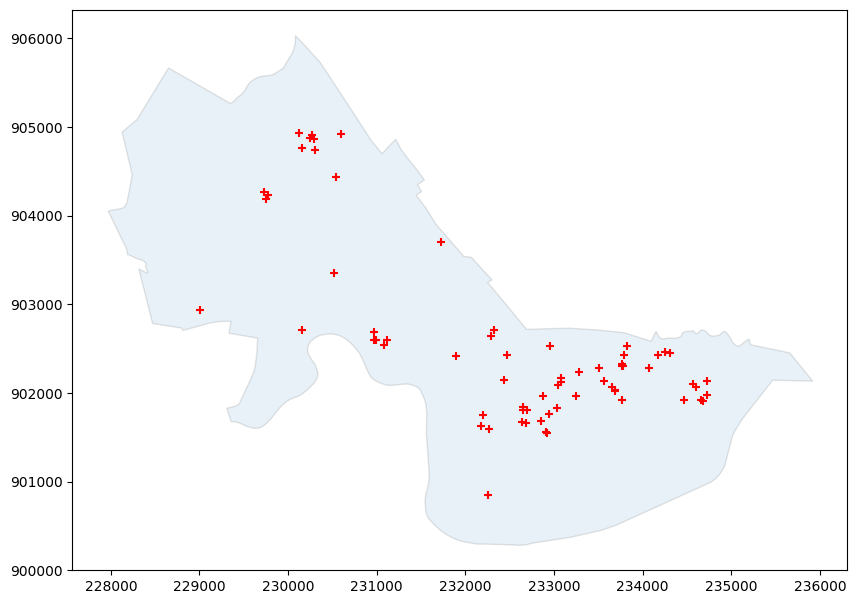

In [83]:
#see layers
base=cambridge.plot(figsize=(10,10),alpha=0.1,edgecolor='black')
airbnb_source_gdf.plot(ax=base,marker="+",color='red')

Target grid:

In [84]:
import tobler

cambridge_grid10=tobler.util.h3fy(cambridge.to_crs(4326), resolution=10).to_crs(cambridge.crs)

In [85]:
#getting points from hexagons
cambridge_target_locations = cambridge_grid10.centroid.get_coordinates()
cambridge_target_locations.head()

,x,y
hex_id,,
8a2a30663ca7fff,234159.215278,901034.986673
8a2a3067541ffff,231082.106852,904430.587303
8a2a30670c0ffff,229399.359754,904975.500670
8a2a306719affff,231480.468945,902981.883402
8a2a30670347fff,230081.200357,903314.983463


Estimation:

In [86]:
#coordinates of the units
airbnb_source_locations = airbnb_source_gdf.get_coordinates()
airbnb_source_locations

,x,y
46,233508.871954,902281.800325
63,233074.491078,902171.996006
64,233073.871347,902128.672579
119,233049.318014,902095.233568
144,229731.373937,904264.207039
...,...,...
1331,230267.094255,904915.194248
1336,233283.722407,902238.187069
1343,232437.188982,902151.222488
1345,232876.954718,901964.463385


In [87]:
airbnb_source_gdf.price #view known rental prices
cambridge_target_locations #view target grid

,x,y
hex_id,,
8a2a30663ca7fff,234159.215278,901034.986673
8a2a3067541ffff,231082.106852,904430.587303
8a2a30670c0ffff,229399.359754,904975.500670
8a2a306719affff,231480.468945,902981.883402
8a2a30670347fff,230081.200357,903314.983463
...,...,...
8a2a306634a7fff,233424.407431,900433.310119
8a2a306752effff,232208.121224,902986.205433
8a2a3067040ffff,228664.488209,904373.574909


Estimation approach: IDW (weighted average based on distance)

<Axes: >

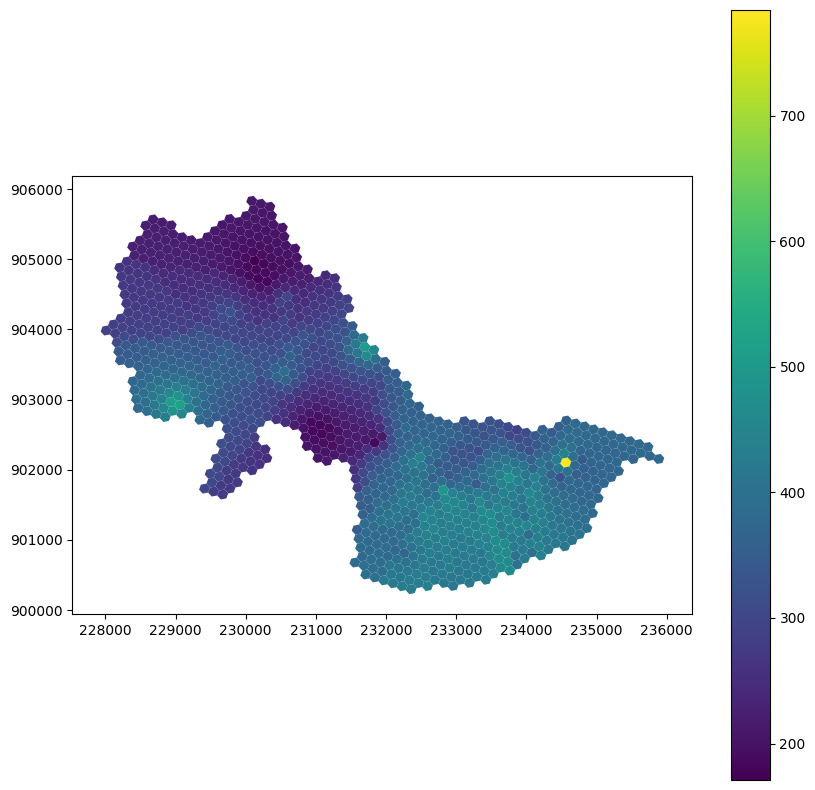

In [99]:
from sklearn.neighbors import KNeighborsRegressor

#using 10 neighboring units
interpolation_IDW = KNeighborsRegressor(n_neighbors=10,
                                            weights="distance").\
                                            fit(airbnb_source_locations,
                                                airbnb_source_gdf.price)

cambridge_grid10["IDW_10"] = interpolation_IDW.predict(cambridge_target_locations)

cambridge_grid10.plot("IDW_10", legend=True,figsize=(10,10))

In [90]:
#geocoding
from geopy.geocoders import Nominatim
from shapely.geometry import Point

geolocator = Nominatim(user_agent="theGeocoder")

myEstate_Address = geolocator.geocode(myEstate)

myEstate_Address #check

Location(125;127, Harvey Street, North Cambridge, Cambridge, Middlesex County, Massachusetts, 02140, United States of America, (42.3975352, -71.1341153, 0.0))

In [95]:
#creating GDF
myEstate_gdf4326 = gpd.GeoDataFrame(
    {'address': [myEstate_Address.address]},
    geometry=[Point(myEstate_Address.longitude, myEstate_Address.latitude)],
    crs="EPSG:4326" #lon/lat
)

#reprojecting
myEstate_gdf = myEstats_gdf4326.to_crs(cambridge.crs)
myEstate_gdf

,address,geometry
0,"125;127, Harvey Street, North Cambridge, Cambr...",POINT (230123.435 905289.489)


Finding where our hexagon is located:

In [100]:
myEstate_gdf.sjoin(
    cambridge_grid10,
    how="left",
    predicate="within"
) #using IDW

,address,geometry,hex_id,IDW_10
0,"125;127, Harvey Street, North Cambridge, Cambr...",POINT (230123.435 905289.489),8a2a3067465ffff,201.892738


KNeighborsRegressor(n_neighbors=10, weights='distance')

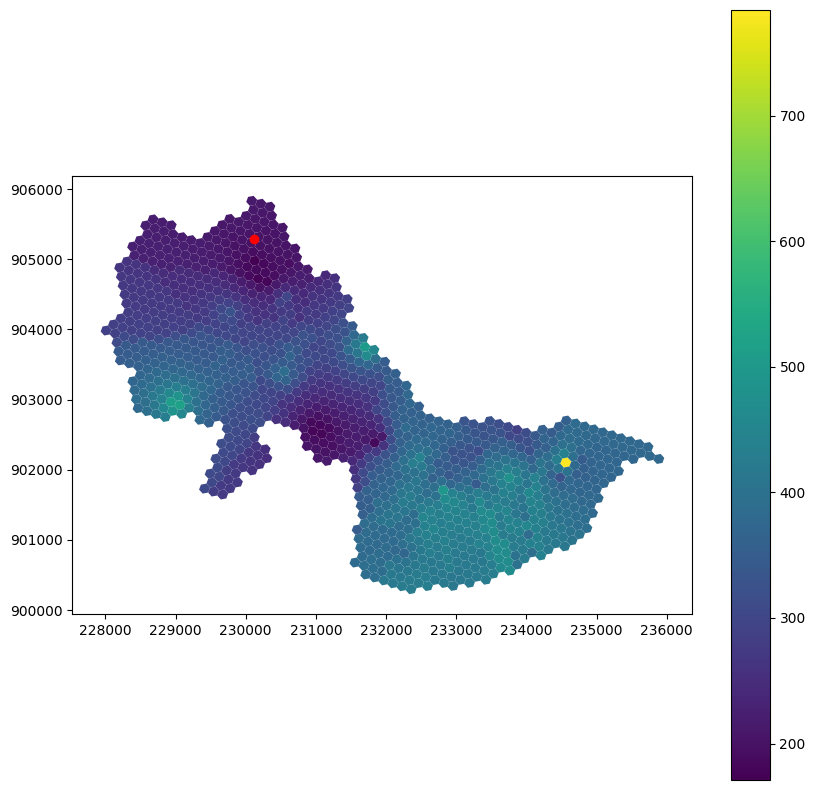

In [98]:
base=cambridge_grid10.plot("IDW_10", legend=True, missing_kwds={'color': 'lightgrey'},figsize=(10,10))
myEstate_gdf.plot(ax=base,color='red')